<a href="https://colab.research.google.com/github/zeuxi141/StockPricePrediction/blob/main/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = 20,10
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

from sklearn.preprocessing import MinMaxScaler
#Read the dataset use the NSE-TATA.csv
url = 'https://github.com/Matt-Jennings-GitHub/Tata-Global-Forcasting/blob/master/NSE-TATAGLOBAL.csv?raw=true'
df = pd.read_csv(url)
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2019-01-04,210.60,214.90,210.00,213.50,213.80,1213181.0,2583.05
1,2019-01-03,214.95,215.35,209.90,210.55,210.05,2096553.0,4433.50
2,2019-01-02,219.00,220.35,213.60,214.20,214.60,1081778.0,2340.31
3,2019-01-01,219.95,221.05,218.05,218.95,219.10,716275.0,1571.63
4,2018-12-31,222.00,223.65,218.85,219.55,219.40,965858.0,2131.09


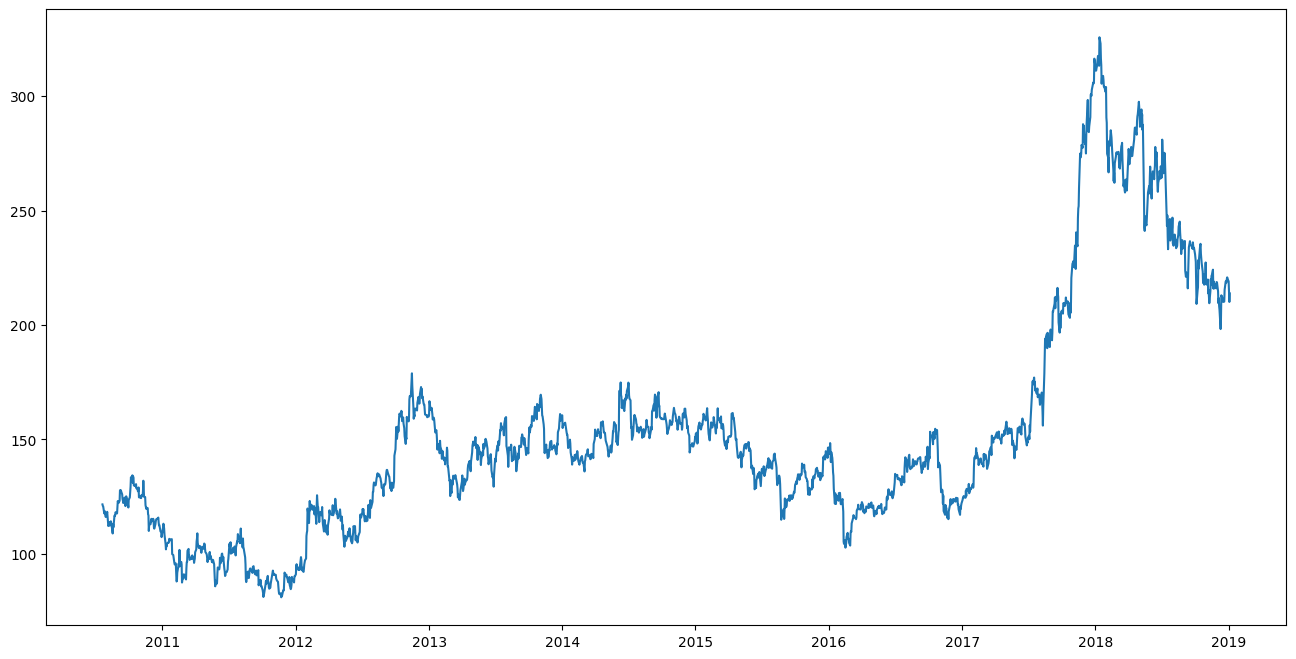

In [ ]:
#Analyze the closing prices from data frames
df["Date"] = pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index = df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"], label='Close Price history')
#

In [ ]:
#Sort the dataset on date time and filter "Date" and "Close" columns:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

<ipython-input-15-c8bc9471ae39>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_dataset["Date"][i]=data['Date'][i]
<ipython-input-15-c8bc9471ae39>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_dataset["Close"][i]=data["Close"][i]


In [ ]:
# print(new_dataset.index)
print(new_dataset.values)

[[Timestamp('2010-07-21 00:00:00') 121.55]
 [Timestamp('2010-07-22 00:00:00') 120.9]
 [Timestamp('2010-07-23 00:00:00') 120.65]
 ...
 [Timestamp('2019-01-02 00:00:00') 214.6]
 [Timestamp('2019-01-03 00:00:00') 210.05]
 [Timestamp('2019-01-04 00:00:00') 213.8]]


In [ ]:
#Normalize the new filtered dataset:
new_dataset.drop("Date", axis=1, inplace=True)

# Chuyển DataFrame thành NumPy array
final_dataset = new_dataset.values

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)

# Tách dữ liệu thành train và validation
train_data = scaled_data[0:987, :]
valid_data = scaled_data[987:, :]


# Chuẩn bị dữ liệu cho mô hình
x_train_data, y_train_data = [], []

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [ ]:
#Build and train the LSTM model:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


927/927 - 28s - 30ms/step - loss: 9.6711e-04


In [ ]:
# Take a sample of a dataset to make stock price predictions using the LSTM model:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [ ]:
#Save the LSTM model:
lstm_model.save("saved_model.h5")

<ipython-input-21-bca2c640ce97>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


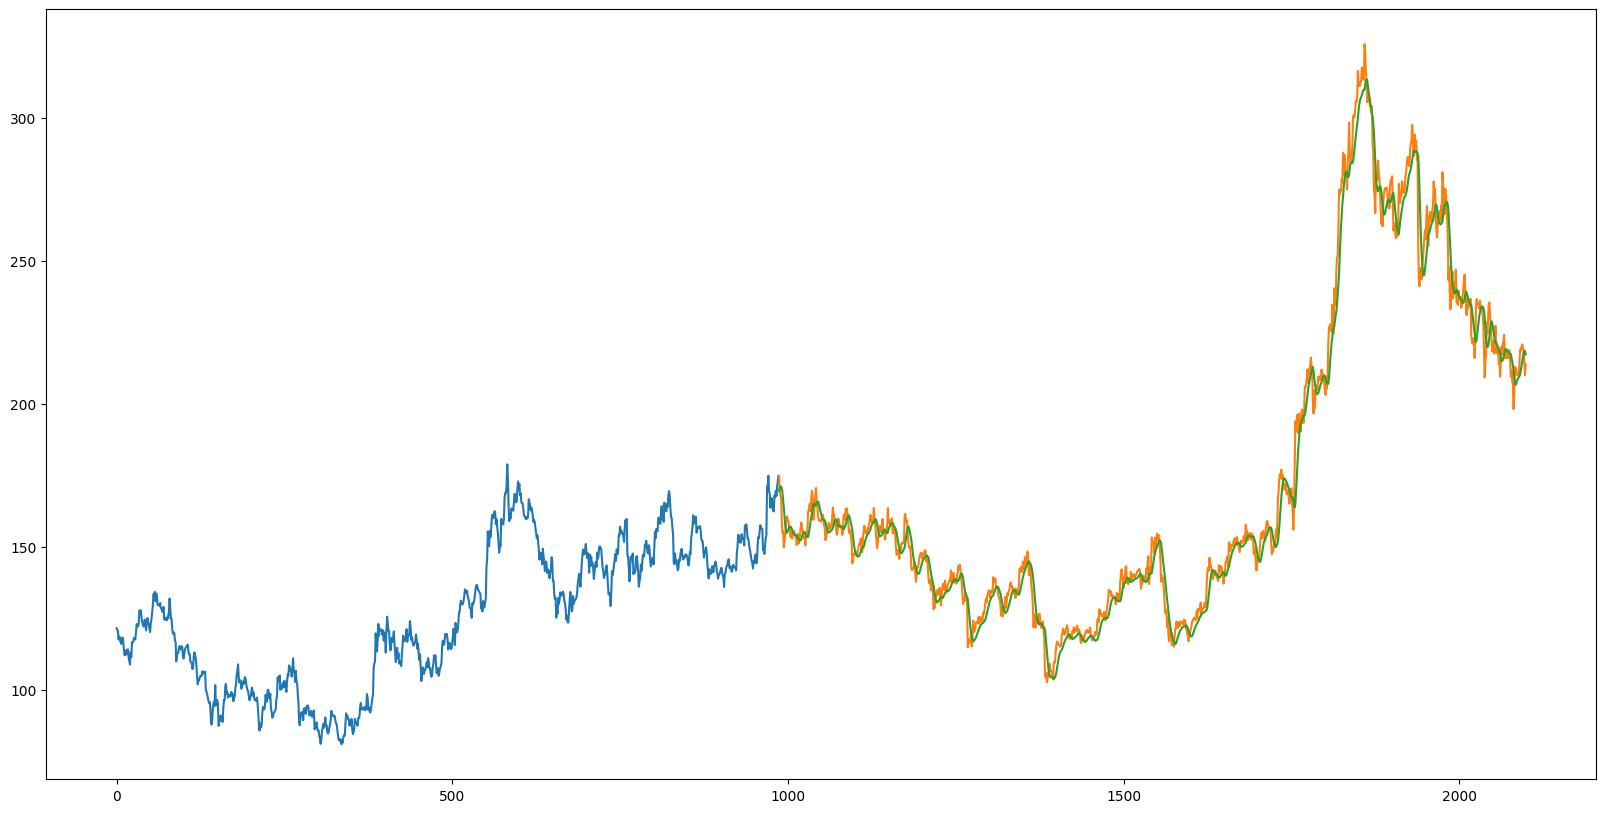

In [ ]:
#Visualize the predicted stock costs with actual stock costs:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

<h1> Build the dashboard using Plotly dash </h1>



In [ ]:
!pip install dash
!pip install dash-html-components
!pip install dash-core-components

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 50.0 MB/s eta 0:00:00


In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf


# List of 10 cryptocurrency tickers
tickers = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'USDT-USD', 'SOL-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'DOT-USD', 'UNI-USD']

print(tickers)
# Fetch data for each ticker
crypto_data = {}
for ticker in tickers:
    crypto_data[ticker] = yf.Ticker(ticker).history(period="1d")

# # Print the fetched data
for ticker, data in crypto_data.items():
    print(f"Data for {ticker}:")
    print(data)
    print("\n")

['BTC-USD', 'ETH-USD', 'BNB-USD', 'USDT-USD', 'SOL-USD', 'ADA-USD', 'XRP-USD', 'DOGE-USD', 'DOT-USD', 'UNI-USD']
Data for BTC-USD:
                                   Open          High           Low  \
Date                                                                  
2024-09-06 00:00:00+00:00  56161.132812  56795.484375  55385.386719   

                                  Close       Volume  Dividends  Stock Splits  
Date                                                                           
2024-09-06 00:00:00+00:00  55799.421875  32234326016        0.0           0.0  


Data for ETH-USD:
                                  Open         High          Low        Close  \
Date                                                                            
2024-09-06 00:00:00+00:00  2367.774658  2405.596191  2323.862061  2349.015625   

                                Volume  Dividends  Stock Splits  
Date                                                             
2024-09-06 00:00:00

In [ ]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)

stock_data = getLocalFiles()

Saving stock_data.csv to stock_data.csv


In [ ]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np


app = dash.Dash()
server = app.server

scaler=MinMaxScaler(feature_range=(0,1))

url = 'https://github.com/Matt-Jennings-GitHub/Tata-Global-Forcasting/blob/master/NSE-TATAGLOBAL.csv?raw=true'
df_nse = pd.read_csv(url)

df_nse["Date"]=pd.to_datetime(df_nse.Date,format="%Y-%m-%d")
df_nse.index=df_nse['Date']


data=df_nse.sort_index(ascending=True,axis=0)
new_data=pd.DataFrame(index=range(0,len(df_nse)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_data["Date"][i]=data['Date'][i]
    new_data["Close"][i]=data["Close"][i]

new_data.index=new_data.Date
new_data.drop("Date",axis=1,inplace=True)

dataset=new_data.values

train=dataset[0:987,:]
valid=dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

x_train,y_train=[],[]

for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)

x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

model=load_model("saved_model.h5")

inputs=new_data[len(new_data)-len(valid)-60:].values
inputs=inputs.reshape(-1,1)
inputs=scaler.transform(inputs)

X_test=[]
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
closing_price=model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

train=new_data[:987]
valid=new_data[987:]
valid['Predictions']=closing_price



df= stock_data


app.layout = html.Div([

    html.H1("Stock Price Analysis Dashboard", style={"textAlign": "center"}),

    dcc.Tabs(id="tabs", children=[

        dcc.Tab(label='NSE-TATAGLOBAL Stock Data',children=[
            html.Div([
                html.H2("Actual closing price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=train.index,
                                y=valid["Close"],
                                mode='markers'
                            )

                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }

                ),
                html.H2("LSTM Predicted closing price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Predicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid.index,
                                y=valid["Predictions"],
                                mode='markers'
                            )

                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }

                )
            ])


        ]),
        dcc.Tab(label='Facebook Stock Data', children=[
            html.Div([
                html.H1("Facebook Stocks High vs Lows",
                        style={'textAlign': 'center'}),

                dcc.Dropdown(id='my-dropdown',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'},
                                      {'label': 'Facebook', 'value': 'FB'},
                                      {'label': 'Microsoft','value': 'MSFT'}],
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto",
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='highlow'),
                html.H1("Facebook Market Volume", style={'textAlign': 'center'}),

                dcc.Dropdown(id='my-dropdown2',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'},
                                      {'label': 'Facebook', 'value': 'FB'},
                                      {'label': 'Microsoft','value': 'MSFT'}],
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto",
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='volume')
            ], className="container"),
        ])


    ])
])


@app.callback(Output('highlow', 'figure'),
              [Input('my-dropdown', 'value')])
def update_graph(selected_dropdown):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    trace2 = []
    for stock in selected_dropdown:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["High"],
                     mode='lines', opacity=0.7,
                     name=f'High {dropdown[stock]}',textposition='bottom center'))
        trace2.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Low"],
                     mode='lines', opacity=0.6,
                     name=f'Low {dropdown[stock]}',textposition='bottom center'))
    traces = [trace1, trace2]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1',
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"High and Low Prices for {', '.join(str(dropdown[i]) for i in selected_dropdown)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M',
                                                       'step': 'month',
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M',
                                                       'step': 'month',
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Price (USD)"})}
    return figure


@app.callback(Output('volume', 'figure'),
              [Input('my-dropdown2', 'value')])
def update_graph(selected_dropdown_value):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    for stock in selected_dropdown_value:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Volume"],
                     mode='lines', opacity=0.7,
                     name=f'Volume {dropdown[stock]}', textposition='bottom center'))
    traces = [trace1]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1',
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"Market Volume for {', '.join(str(dropdown[i]) for i in selected_dropdown_value)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M',
                                                       'step': 'month',
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M',
                                                       'step': 'month',
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Transactions Volume"})}
    return figure


if __name__=='__main__':
    app.run_server(debug=True)

<ipython-input-26-de0f284227a8>:2: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-26-de0f284227a8>:3: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html
<ipython-input-26-de0f284227a8>:28: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-26-de0f284227a8>:29: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


<ipython-input-26-de0f284227a8>:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>

### **Huấn luyện mô hình** ###

* Sử dụng Keras (Sequential, LSTM, Dense): Dùng để xây dựng và huấn luyện mô hình LSTM cho dự báo chuỗi thời gian.
* Chia dữ liệu thành hai phần:
  * Tập huấn luyện: 80% dữ liệu.
  * Tập kiểm tra (valid): 20% còn lại.

* Chuẩn hóa dữ liệu **Close** (giá đóng cửa) vào khoảng từ 0 đến 1 bằng MinMaxScaler.



[*********************100%***********************]  1 of 1 completed
<ipython-input-27-610c4ff427e2>:20: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-27-610c4ff427e2>:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1108/1108 - 35s - 32ms/step - loss: 0.0032
Epoch 2/20
1108/1108 - 38s - 34ms/step - loss: 0.0016
Epoch 3/20
1108/1108 - 41s - 37ms/step - loss: 0.0012
Epoch 4/20
1108/1108 - 30s - 27ms/step - loss: 8.6363e-04
Epoch 5/20
1108/1108 - 31s - 28ms/step - loss: 8.3150e-04
Epoch 6/20
1108/1108 - 40s - 36ms/step - loss: 7.7088e-04
Epoch 7/20
1108/1108 - 44s - 40ms/step - loss: 7.3805e-04
Epoch 8/20
1108/1108 - 37s - 34ms/step - loss: 7.0403e-04
Epoch 9/20
1108/1108 - 41s - 37ms/step - loss: 7.3061e-04
Epoch 10/20
1108/1108 - 42s - 38ms/step - loss: 6.8875e-04
Epoch 11/20
1108/1108 - 30s - 28ms/step - loss: 7.0912e-04
Epoch 12/20
1108/1108 - 42s - 38ms/step - loss: 6.5000e-04
Epoch 13/20
1108/1108 - 40s - 37ms/step - loss: 6.4707e-04
Epoch 14/20
1108/1108 - 41s - 37ms/step - loss: 6.1191e-04
Epoch 15/20
1108/1108 - 51s - 46ms/step - loss: 6.3589e-04
Epoch 16/20
1108/1108 - 30s - 27ms/step - loss: 6.4043e-04
Epoch 17/20
1108/1108 - 41s - 37ms/step - loss: 5.9940e-04
Epoch 18/20
1108/1108 - 42s -

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


<ipython-input-27-610c4ff427e2>:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



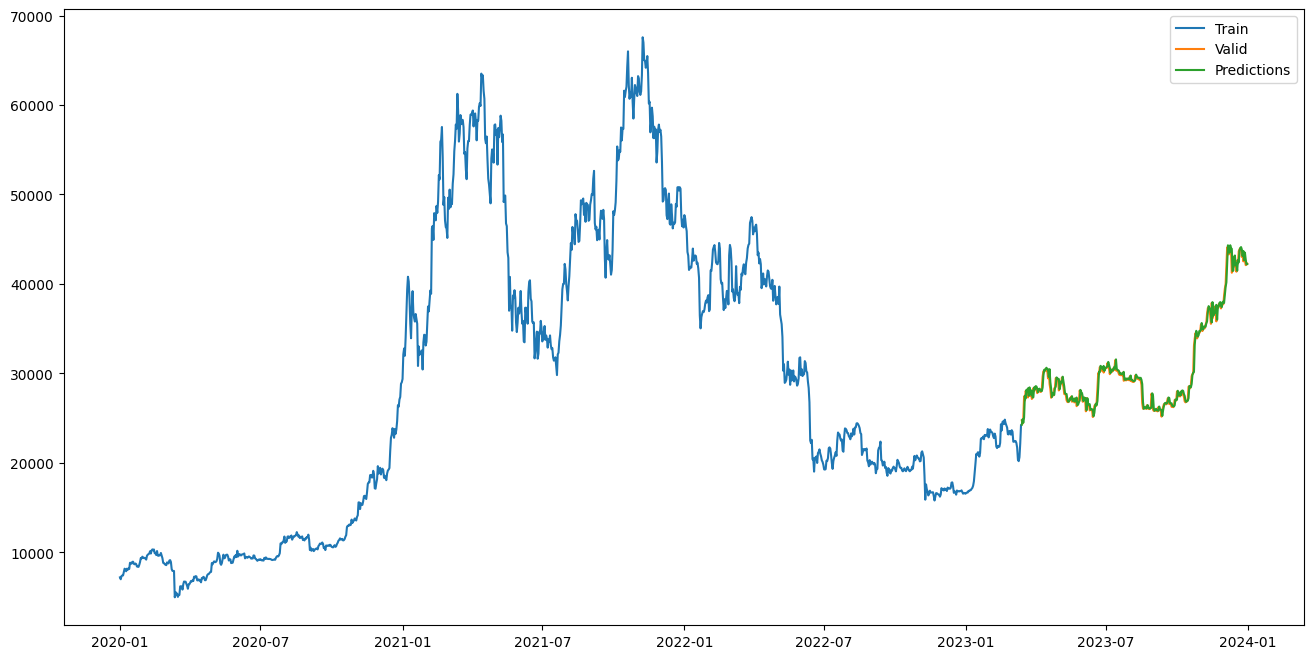

In [ ]:
#train model for predict - Run first
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Fetch cryptocurrency data
crypto_symbol = 'BTC-USD'
df_crypto = yf.download(crypto_symbol, start="2020-01-01", end="2024-01-01")

# Preprocess the data
df_crypto["Date"] = df_crypto.index
data = df_crypto.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df_crypto)), columns=['Date', 'Close'])

for i in range(0, len(data)):
    new_data["Date"][i] = data['Date'][i]
    new_data["Close"][i] = data["Close"][i]

new_data.index = new_data.Date
new_data.drop("Date", axis=1, inplace=True)

dataset = new_data.values
train = dataset[0:int(0.8 * len(dataset)), :]
valid = dataset[int(0.8 * len(dataset)):, :]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60, len(train)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

# Save the model
model.save("saved_model.h5")

# Predicting
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

train = new_data[:int(0.8 * len(dataset))]
valid = new_data[int(0.8 * len(dataset)):]
valid['Predictions'] = closing_price

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(train["Close"], label="Train")
plt.plot(valid["Close"], label="Valid")
plt.plot(valid["Predictions"], label="Predictions")
plt.legend()
plt.show()


**Input:**
* Dữ liệu lịch sử tiền điện tử: Lấy từ Yahoo Finance thông qua thư viện yfinance, bao gồm giá mở cửa, giá đóng cửa, giá cao nhất, giá thấp nhất và khối lượng giao dịch của các loại tiền điện tử (như BTC, ETH, BNB, v.v.) trong khoảng thời gian từ năm 2020 đến năm 2024.
* Lựa chọn của người dùng: Người dùng tương tác với bảng điều khiển bằng cách chọn loại tiền điện tử và khung thời gian muốn xem thông qua dropdown và các tab. Dữ liệu này sẽ được sử dụng để cập nhật biểu đồ và thông tin dựa trên lựa chọn.

**Output**
* Biểu đồ giá đóng cửa thực tế và dự đoán: Hiển thị trên bảng điều khiển, bao gồm giá đóng cửa thực tế của tiền điện tử và giá được dự đoán bởi mô hình LSTM.
* Biểu đồ giá cao/thấp và khối lượng giao dịch: Dựa vào loại tiền điện tử mà người dùng chọn, bảng điều khiển sẽ hiển thị biểu đồ mức giá cao nhất, thấp nhất, và khối lượng giao dịch lịch sử của tiền điện tử đó.

In [ ]:
# Hàm thực hiện dự đoán cho một đồng tiền cụ thể
def predict_crypto(symbol):
    df_crypto = crypto_data[symbol]
    df_crypto["Date"] = df_crypto.index

    data = df_crypto.sort_index(ascending=True, axis=0)
    new_data = pd.DataFrame(index=range(0, len(df_crypto)), columns=['Date', 'Close'])

    for i in range(0, len(data)):
        new_data["Date"][i] = data['Date'][i]
        new_data["Close"][i] = data["Close"][i]

    new_data.index = new_data.Date
    new_data.drop("Date", axis=1, inplace=True)

    dataset = new_data.values
    train = dataset[0:int(0.8 * len(dataset)), :]
    valid = dataset[int(0.8 * len(dataset)):, :]

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    for i in range(60, len(train)):
        x_train.append(scaled_data[i-60:i, 0])
        y_train.append(scaled_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Sử dụng model đã huấn luyện
    inputs = new_data[len(new_data) - len(valid) - 60:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(60, inputs.shape[0]):
        X_test.append(inputs[i-60:i, 0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)

    valid = new_data[int(0.8 * len(dataset)):]
    valid['Predictions'] = closing_price

    return valid


In [38]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import plotly.graph_objs as go
from dash.dependencies import Input, Output
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import yfinance as yf

app = dash.Dash()
server = app.server

scaler = MinMaxScaler(feature_range=(0, 1))

# List of cryptocurrencies
crypto_symbols = ['BTC-USD', 'ETH-USD', 'BNB-USD', 'USDT-USD', 'XRP-USD', 'ADA-USD', 'DOGE-USD', 'SOL-USD', 'DOT-USD', 'UNI1-USD']

# Fetch data from Yahoo Finance
crypto_data = {}
for symbol in crypto_symbols:
    crypto_data[symbol] = yf.download(symbol, start="2020-01-01", end="2024-01-01")

# Process the data for a single cryptocurrency (e.g., BTC-USD)
df_crypto = crypto_data['BTC-USD']
df_crypto["Date"] = df_crypto.index

data = df_crypto.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df_crypto)), columns=['Date', 'Close'])

for i in range(0, len(data)):
    new_data["Date"][i] = data['Date'][i]
    new_data["Close"][i] = data["Close"][i]

new_data.index = new_data.Date
new_data.drop("Date", axis=1, inplace=True)

dataset = new_data.values
train = dataset[0:int(0.8 * len(dataset)), :]
valid = dataset[int(0.8 * len(dataset)):, :]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60, len(train)):
    x_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Load the trained model
model = load_model("saved_model.h5")

inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

train = new_data[:int(0.8 * len(dataset))]
valid = new_data[int(0.8 * len(dataset)):]
valid['Predictions'] = closing_price

app.layout = html.Div([
    html.H1("Cryptocurrency Price Analysis Dashboard", style={"textAlign": "center"}),

    dcc.Tabs(id="tabs", children=[

        dcc.Tab(label='BTC-USD Data', children=[
            html.Div([
                html.H2("Actual closing price", style={"textAlign": "center"}),
                dcc.Graph(
                    id="Actual Data",
                    figure={
                        "data": [
                            go.Scatter(
                                x=train.index,
                                y=valid["Close"],
                                mode='markers'
                            )
                        ],
                        "layout": go.Layout(
                            title='Scatter plot',
                            xaxis={'title': 'Date'},
                            yaxis={'title': 'Closing Rate'}
                        )
                    }
                ),
                html.H2("LSTM Predicted closing price", style={"textAlign": "center"}),
                dcc.Graph(
                    id="Predicted Data",
                    figure={
                        "data": [
                            go.Scatter(
                                x=valid.index,
                                y=valid["Predictions"],
                                mode='markers'
                            )
                        ],
                        "layout": go.Layout(
                            title='Scatter plot',
                            xaxis={'title': 'Date'},
                            yaxis={'title': 'Closing Rate'}
                        )
                    }
                )
            ])
        ]),
        dcc.Tab(label='Cryptocurrency Data', children=[
            html.Div([
                html.H1("Cryptocurrency Prices High vs Lows", style={'textAlign': 'center'}),
                dcc.Dropdown(id='crypto-dropdown-highlow',
                             options=[{'label': symbol, 'value': symbol} for symbol in crypto_symbols],
                             multi=True, value=['BTC-USD'],
                             style={"display": "block", "margin-left": "auto",
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='highlow'),
                html.H1("Cryptocurrency Market Volume", style={'textAlign': 'center'}),
                dcc.Dropdown(id='crypto-dropdown-volume',
                             options=[{'label': symbol, 'value': symbol} for symbol in crypto_symbols],
                             multi=True, value=['BTC-USD'],
                             style={"display": "block", "margin-left": "auto",
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='volume'),
                dcc.Dropdown(
                  id='crypto-dropdown-prediction',
                  options=[{'label': symbol, 'value': symbol} for symbol in crypto_symbols],
                  value='BTC-USD',  # Giá trị mặc định là BTC-USD
                  style={"display": "block", "margin-left": "auto", "margin-right": "auto", "width": "60%"}
                ),
                dcc.Graph(id='Predicted Data')

            ], className="container"),
        ])
    ])
])

@app.callback(Output('highlow', 'figure'),
              [Input('crypto-dropdown-highlow', 'value')])
def update_graph(selected_dropdown):
    trace1 = []
    trace2 = []
    for symbol in selected_dropdown:
        trace1.append(
            go.Scatter(x=crypto_data[symbol].index,
                       y=crypto_data[symbol]["High"],
                       mode='lines', opacity=0.7,
                       name=f'High {symbol}', textposition='bottom center'))
        trace2.append(
            go.Scatter(x=crypto_data[symbol].index,
                       y=crypto_data[symbol]["Low"],
                       mode='lines', opacity=0.6,
                       name=f'Low {symbol}', textposition='bottom center'))
    traces = [trace1, trace2]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1',
                                            '#FF7400', '#FFF400', '#FF0056'],
                                  height=600,
                                  title=f"High and Low Prices for {', '.join(str(i) for i in selected_dropdown)} Over Time",
                                  xaxis={"title": "Date",
                                         'rangeselector': {'buttons': list([{'count': 1, 'label': '1M',
                                                                             'step': 'month',
                                                                             'stepmode': 'backward'},
                                                                            {'count': 6, 'label': '6M',
                                                                             'step': 'month',
                                                                             'stepmode': 'backward'},
                                                                            {'step': 'all'}])},
                                         'rangeslider': {'visible': True}, 'type': 'date'},
                                  yaxis={"title": "Price (USD)"})}
    return figure

@app.callback(Output('volume', 'figure'),
              [Input('crypto-dropdown-volume', 'value')])
def update_graph(selected_dropdown_value):
    trace1 = []
    for symbol in selected_dropdown_value:
        trace1.append(
            go.Scatter(x=crypto_data[symbol].index,
                       y=crypto_data[symbol]["Volume"],
                       mode='lines', opacity=0.7,
                       name=f'Volume {symbol}', textposition='bottom center'))
    traces = [trace1]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1',
                                            '#FF7400', '#FFF400', '#FF0056'],
                                  height=600,
                                  title=f"Market Volume for {', '.join(str(i) for i in selected_dropdown_value)} Over Time",
                                  xaxis={"title": "Date",
                                         'rangeselector': {'buttons': list([{'count': 1, 'label': '1M',
                                                                             'step': 'month',
                                                                             'stepmode': 'backward'},
                                                                            {'count': 6, 'label': '6M',
                                                                             'step': 'month',
                                                                             'stepmode': 'backward'},
                                                                            {'step': 'all'}])},
                                         'rangeslider': {'visible': True}, 'type': 'date'},
                                  yaxis={"title": "Transactions Volume"})}
    return figure

@app.callback(
    Output('Predicted Data', 'figure'),
    [Input('crypto-dropdown-prediction', 'value')]
)
def update_prediction(selected_symbol):
    # Thực hiện dự đoán cho đồng tiền đã chọn
    predicted_data = predict_crypto(selected_symbol)

    figure = {
        "data": [
            go.Scatter(
                x=predicted_data.index,
                y=predicted_data["Predictions"],
                mode='lines',
                name='Predictions'
            ),
            go.Scatter(
                x=predicted_data.index,
                y=predicted_data["Close"],
                mode='lines',
                name='Actual'
            )
        ],
        "layout": go.Layout(
            title=f'LSTM Predicted vs Actual Closing Prices for {selected_symbol}',
            xaxis={
                'title': 'Date',
                'rangeselector': {
                    'buttons': [
                        {'count': 1, 'label': '1M', 'step': 'month', 'stepmode': 'backward'},
                        {'count': 6, 'label': '6M', 'step': 'month', 'stepmode': 'backward'},
                        {'step': 'all'}
                    ]
                },
                'rangeslider': {'visible': True},
                'type': 'date'
            },
            yaxis={'title': 'Price (USD)'},
            height=600
        )
    }

    return figure



    return {}

if __name__ == '__main__':
    app.run_server(debug=True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-38-625940b2bc97>:33: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-38-625940b2bc97>:34: Futu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


<ipython-input-38-625940b2bc97>:72: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



---------------------------------------------------------------------------
DuplicateIdError                          Traceback (most recent call last)
DuplicateIdError: Duplicate component id found in the initial layout: `Predicted Data`



<IPython.core.display.Javascript object>